# Analysis
### This code analyzes tables with the following removed:
* **Multi** terrain type
* Any row that has null entries which was a consequence of scraping thousands of webpages with sometimes different table structures; this killed about 27% of the scraped data
* Chip time and gun time have been combined to form a minimum time in mins
* Deleted **ALL** races without the corresponding GPX file therefore this is the cross-referenced output
* Some GPX information has been added to tables, e.g. elevation and sigma

In [1]:
race_type = '10M'

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from sklearn import metrics
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import utils
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Important maps
conversion_map = {'1M':1.0, '3K':1.86, '2M':2.0, '5K':3.1, '4M':4.0,
                 '5M':5.0, '6M':6.0, '10K':6.2, 'QM':6.55, '7M':7.0,
                 '10M':10.0, 'HM':13.1, 'Mar':26.2}
race_order= ['1M', '3K', '2M', '5K', '4M','5M', '6M', '10K',
             'QM', '7M', '10M', 'HM', 'Mar']
age_order = ['U15','U17','U20','U23','SEN','V35','V40','V45',
             'V50','V55','V60','V65','V70','V75','V80','V85']
#age_map = {'U11':0,'U13':0,'U15':0,'U17':0,'U20':0,'U23':0,
#           'SEN':1,'V35':2,'V40':2,'V45':3,'V50':3,'V55':4,
#           'V60':4,'V65':5,'V70':5,'V75':5,'V80':5,'V85':5}
age_map = {'U11':0,'U13':1,'U15':2,'U17':3,'U20':4,'U23':5,
                  'SEN':6,'V35':7,'V40':8,'V45':9,'V50':10,'V55':11,
                  'V60':12,'V65':13,'V70':14,'V75':15,'V80':16,'V85':17}
dist_map = {'1M':1, '3K':2, '2M':3, '5K':4, '4M':5,
            '5M':6, '6M':7, '10K':8, 'QM':9, '7M':10,
            '10M':11, 'HM':12, 'Mar':13}

In [4]:
speed = 3.1*1.6 #mph
if race_type == 'Mar':
    speed = 3.1*1.4
dist = conversion_map[race_type]
walk_time = (dist / speed)* 60
print('60%% faster than walking is expected to take %1.1f minutes' % walk_time)
print('TIME CUT = %1.3f' % walk_time)
TIME_CUT = walk_time

60% faster than walking is expected to take 121.0 minutes
TIME CUT = 120.968


In [5]:
datadir = '/home/freddy/insight/data/'
filename = datadir + 'data_overlaps_with_gpx_cleaned.csv'
df = pd.read_csv(filename)
print('rows, cols = {0}, {1}'.format(df.shape[0], df.shape[1]))
df=df.drop(columns=['Unnamed: 0'], axis=1)

rows, cols = 104941, 13


In [6]:
df=df[df.age_group != 'V115']

In [7]:
df_old = df

In [8]:
df_old.groupby(['race_title'],as_index=False).size()

race_title
10K    15650
10M     2113
1M       199
2M        59
3K       421
4M       216
5K      2623
5M      4791
6M       272
7M       411
HM      3802
Mar    73948
QM       434
dtype: int64

In [9]:
#df_old.groupby(['age_group'],as_index=False).size()

In [10]:
df=df[df.race_title==race_type]
subdf=df[df.race_title==race_type].groupby(['meeting_id','sex','age_group','race_title'],as_index=False)['min_time'].median()

In [11]:
if race_type == '10K':
    f, ax = plt.subplots(1,1, figsize=(12,4))
    A=df.groupby(['event_title','min_time'], as_index=False).count()
    Ar = A[A.event_title=='RunThrough Olympic Park 10K']
    Al = A[A.event_title=='RunThrough Chase The Moon Olympic Park 10K']
    plt.hist(list(Al.min_time.values), 50, 
             alpha=0.5, label='Day', facecolor='g')
    plt.hist(list(Ar.min_time.values), 50, 
             alpha=0.5, label='Night',facecolor='b')
    plt.legend(loc='upper right',frameon=False, prop={'size':20})
    plt.grid(True)
    plt.xlabel('Median Finish Time (min)')
    plt.show()

In [12]:
location_df = df.groupby(['meeting_id','race_location','event_title'],as_index=False).count()
events = set(list(location_df['event_title'].values))

event_map = {}
for i in events:
    subdf = location_df.loc[location_df['event_title']==i]
    subdf_map = {}
    for index, row in subdf.iterrows():
        ID  = row.meeting_id
        loc = row.race_location
        subdf_map[ID] = loc
    event_map[i] = subdf_map
temp = dict(zip(location_df.meeting_id,location_df.event_title))

In [13]:
id_avgtime = df.groupby(['meeting_id'], as_index=False)['min_time'].median()
times = dict(zip(id_avgtime.meeting_id, id_avgtime.min_time))
time_bar = 0.0
for i in list(times.values()):
    time_bar += i
time_bar /= float(len(list(times.values())))

In [14]:
fast=(df.sort_values('min_time').groupby(['meeting_id'],as_index=False).first())['min_time'].values

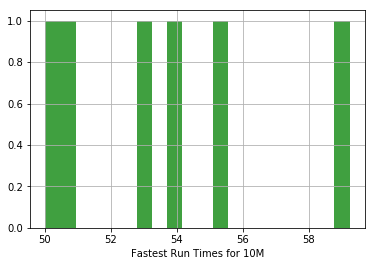

In [15]:
n, bins, patches = plt.hist(fast, 20,
                            facecolor='g', alpha=0.75)
plt.grid(True)
plt.xlabel('Fastest Run Times for %s' % race_type)
plt.show()

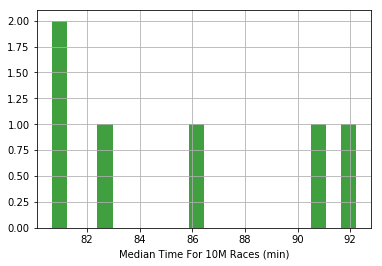

In [16]:
n, bins, patches = plt.hist(times.values(), 20,
                            facecolor='g', alpha=0.75)
plt.grid(True)
plt.xlabel('Median Time For %s Races (min)' % race_type)
plt.show()

In [17]:
def get_dt(row):
    time = row.min_time
    med_time = times[row.meeting_id]
    return float(time-med_time)

In [18]:
df['dt'] = df.apply(get_dt,axis=1)
print(df.shape)
df = df.drop(df[df.min_time > TIME_CUT].index)
print(df.shape)

(2113, 13)
(2060, 13)


In [19]:
Y = []
for index,row in df.iterrows():
    sex  = row.sex
    age  = row.age_group
    time = row.min_time 
    ID   = row.meeting_id
    # Need a smarter method for this...I tried building a dictionary like I would
    # normally do in C++ but it doesn't work that way in python to my knowledge
    #temp_row = subdf.loc[(subdf['age_group']==age) & 
    #                     (subdf['sex']==sex) &
    #                     (subdf['meeting_id'] == ID)]
    #avg_time = (temp_row.min_time).item()
    avg_time = times[ID]
    Y.append(0 if (time<=avg_time) else 1)

In [20]:
Y_dt = list(df['dt'])

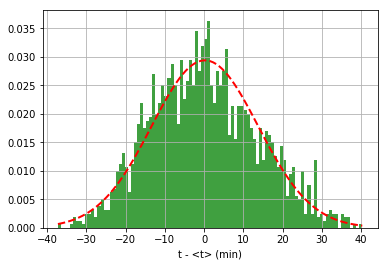

Mu,sigma = 0.186, 13.579


In [21]:
from scipy.stats import norm
n, bins, patches = plt.hist(Y_dt, 100, density=True, 
                            facecolor='g', alpha=0.75)
#plt.axis([10, 35, 0.0, 0.175])
plt.grid(True)
plt.xlabel('t - <t> (min)')
(mu,sig) = norm.fit(Y_dt)
y = mlab.normpdf(bins, mu, sig)
l = plt.plot(bins, y, 'r--', linewidth=2)

plt.show()
print('Mu,sigma = %1.3f, %1.3f' % (mu,sig))

In [22]:
X = df

In [23]:
norm = conversion_map[race_type]
X['sum_up'] = X['sum_up']/norm
X['sigma']  = X['sigma']/norm
print('Normalization = %1.4f miles' % norm )

Normalization = 10.0000 miles


In [24]:
gpx = X.groupby(['meeting_id'],as_index=False).mean()
gpx = gpx.drop(['position', 'race_dist', 'min_time'], axis=1)

In [25]:
X = X.drop(['position','meeting_id', 'race_title', 'race_dist',
            'event_title','race_location', 'dt'], axis=1)

In [26]:
for xrow in [X]:
    xrow['sex'] = xrow['sex'].map( {'W': 1, 'M': 2} ).astype(int)
    xrow['age_group'] = xrow['age_group'].map( age_map )

## Split into training and testing

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test  = \
    train_test_split(X, Y_dt, test_size=0.2, random_state=42)

In [28]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std  = stdsc.fit_transform(X_test)

## Logistic Regression
This was attempt number 1 and too simple as the output has been forced to be binary

In [29]:
clf = linear_model.LogisticRegression()
clf.fit(X, Y)
beta = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(clf.coef_))], axis = 1)
print('Logistic Regression Results:')
print(beta)

Logistic Regression Results:
           0         0
0  age_group -0.131115
1        sex -0.972266
2   min_time  0.240147
3     sum_up -0.177326
4      sigma  0.870260
5       diff -0.200984


In [30]:
X.head()

,age_group,sex,min_time,sum_up,sigma,diff
28282,6,2,50.016667,33.54,1.8232,-14.0
28283,6,2,52.800000,33.54,1.8232,-14.0
28284,6,2,53.250000,33.54,1.8232,-14.0
28285,6,2,55.050000,33.54,1.8232,-14.0
28286,8,2,55.816667,33.54,1.8232,-14.0


In [31]:
reg = linear_model.LinearRegression().fit(X, Y_dt)
lr = reg.coef_
beta_dict = {'age_group': lr[0], 'sex':lr[1], 
             'min_time':lr[2], 'sum_up':lr[3], 'sigma':lr[4],
            'diff':lr[5]}
beta = pd.DataFrame(list(beta_dict.items()))
print('Linear Regression Results:')
print(beta)

Linear Regression Results:
           0         1
0  age_group -0.032009
1        sex -0.031409
2   min_time  0.995410
3     sum_up -0.535417
4      sigma  4.598496
5       diff -0.550699


In [32]:
reg_v2 = linear_model.LinearRegression().fit(X_train, y_train)
y_pred = reg_v2.predict(X_test)
score = reg_v2.score(X_test,y_test)
print('Score = {0}'.format(score))
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Score = 0.9898849390722274
1.32845114121


In [33]:
from sklearn.metrics import mean_squared_error
ridge = linear_model.Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
ridge.fit(X_train, y_train)
    # calculate errors
new_train_error = mean_squared_error(y_train, ridge.predict(X_train))
new_test_error = mean_squared_error(y_test, ridge.predict(X_test))
print(new_train_error, new_test_error)
ridge.coef_

1.67234716508 1.76528221316


array([-0.03809272,  0.04090719,  0.99694197, -0.53304881,  4.55425511,
       -0.55079063])

In [34]:
d = []
for index, row in X.iterrows():
    rowidx=0
    sum = 0.0
    for i in row:
        sum += i*beta.values[rowidx][1]
        rowidx+=1
    d.append(sum)

Mu,sigma = 80.429, 13.516


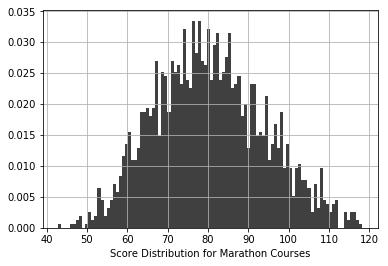

In [35]:
from scipy.stats import norm
n, bins, patches = plt.hist(d, 100, density=True, 
                            facecolor='black', alpha=0.75)
#plt.axis([20, 120, 0.1, 200])
plt.grid(True)
plt.xlabel('Score Distribution for Marathon Courses')
(mu,sig) = norm.fit(d)
y = mlab.normpdf(bins, mu, sig)
#l = plt.plot(bins, y, 'r--', linewidth=4)
#plt.yscale('log')
print('Mu,sigma = %1.3f, %1.3f' % (mu,sig))
plt.show()

In [36]:
def integrate(lo, hi, n, bins):
    integral = 0.0
    for idx in range(lo,hi):
        integral += n[idx] * (bins[idx+1]-bins[idx])
    return integral

In [37]:
xvals, yvals, dx = [],[],[]
for idx in range(0,len(n)):
    integral = integrate(0, idx, n, bins)
    binpos =  0.5*(bins[idx+1] + bins[idx])
    dx.append(bins[idx+1] - bins[idx])
    success = False
    if integral > 0.995:
        success = True
        integral = 1.0
    xvals.append(binpos)
    yvals.append(integral)
    if success:
        break

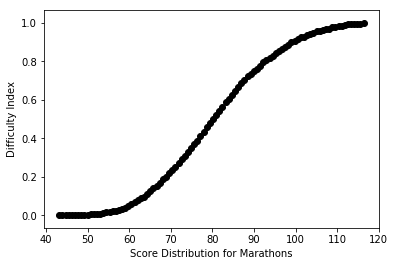

In [38]:
plt.scatter(xvals,yvals,color='black')
plt.xlabel('Score Distribution for Marathons')
plt.ylabel('Difficulty Index')
plt.show()

In [39]:
dump_output = 'inputs/{0}/'.format(race_type)
#dump_output = 'inputs/testing/10K/'

In [40]:
# Print out age and sex map
f1 = open('{0}age_map_{1}.csv'.format(dump_output,race_type), 'w')
for key, val in age_map.items():
    f1.write('%s,%d\n'%(key,val))
f1.close()

In [41]:
# save the betas
beta.to_csv('{0}beta_{1}.csv'.format(dump_output,race_type),sep=',', 
            index=False, header=False)

In [42]:
# Write out the integral plot
f = open('{0}d_dist_{1}.csv'.format(dump_output,race_type), 'w')
f.write('bin,xval,yval,dx\n')
for idx in range(0,len(xvals)):
    f.write('%d,%1.5f,%1.5f,%1.5f\n' % (idx,xvals[idx],yvals[idx], dx[idx]))
f.close()

In [43]:
id_avgtime.to_csv('{0}avg_times_{1}.csv'.format(dump_output,race_type),sep=',',
            index=False)

In [44]:
# Write out the GPX information used
gpx.to_csv('{0}gpx_info_{1}.csv'.format(dump_output,race_type),sep=',', index=False)

In [45]:
# Print out the event list
f2 = open('{0}event_title_list_{1}.csv'.format(dump_output,race_type), 'w')
f2.write('event\n')
for key, val in event_map.items():
    f2.write('%s\n'%key)
f2.close()

In [46]:
f3 = open('{0}event_title_list_v2_{1}.csv'.format(dump_output,race_type), 'w')
f3.write('ID,event\n')
for key, val in temp.items():
    f3.write('%d,%s\n'%(key,val))
f3.close()

In [47]:
# LETS MERGE ANYTHING USEFUL FOR LATER CALCULATIONS
frame2sql_temp = id_avgtime
frame2sql = pd.merge(frame2sql_temp,gpx,on='meeting_id')
evt_temp = pd.DataFrame.from_dict(temp,orient='index')
output = frame2sql.merge(evt_temp,left_on='meeting_id',right_index=True)
output['race_type'] = race_type
output.to_csv('{0}OUTPUT_{1}.csv'.format(dump_output,race_type),sep=',', index=False)